In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt
from sklearn.manifold import TSNE

from general_tools.in_out.basics import unpickle_data
from general_tools.in_out import create_dir
from general_tools.notebook.tf import reset_tf_graph

from general_tools.clustering.plt import plot_2d_embedding_in_grid_greedy_way, \
                                         plot_2d_embedding_in_grid_forceful

from general_tools.plotting import stack_images_horizontally

from geo_tool import Point_Cloud

import tf_lab.point_clouds.in_out as pio

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params, pc_sampler, pc_loader
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import pairwise_distances
import random

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [15]:
def incremental_farthest_search(all_dists, k, exluded_points=None, seed=None):
    '''Returns k points (unique indices) that are picked in a greedy way
    which attempts to maximize their minimum pairwise distances. The seed controls the 
    resulting indices.
    '''    
    remaining_points = np.arange(all_dists.shape[0])

    if exluded_points is not None:
        remaining_points = np.setdiff1d(remaining_points, exluded_points)
        
    if seed is not None:
        np.random.seed(seed)
        
    solution_set = [np.random.choice(remaining_points, 1)[0]]    
    remaining_points = np.setdiff1d(remaining_points, solution_set, assume_unique=True)
    
    for _ in range(k-1):
        max_dist = -1
        next_point = -1
        min_distances = []
        for p in remaining_points:
            min_d = np.min(all_pdists[p, solution_set])
            if min_d > max_dist:
                max_dist = min_d
                next_point = p            

        solution_set.append(next_point)
        remaining_points = np.setdiff1d(remaining_points, next_point, assume_unique=True)
    
    assert(len(np.unique(solution_set)) == k)
    assert(len(solution_set) == k)
    assert(len(np.intersect1d(remaining_points, np.array(solution_set))) == 0)
    
    return solution_set

def evaluate_solution(solution_set):
    distance = lambda a,b: np.linalg.norm(np.array(a)-np.array(b)) 
    return sum([distance(a, b) for a, b in zip(solution_set[:-1], solution_set[1:])])

def detect_outliers(features, outlier_fraction, random_seed):
    '''
    '''
    clf = IsolationForest(max_samples=200, random_state=random_seed, contamination=outlier_fraction)
    clf.fit(features)
    y_pred = clf.predict(features)
    outliers = np.where(y_pred == -1)[0]
    print len(outliers)
    return outliers

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
random_seed = 42
outlier_fraction = 0.3 # Percent of data instances that will be automatically disreguarded.
n_exemplars = 140 # Source instances that will be used to create contrasting triplets.
top_data_dir = top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

In [7]:
# load AE model
class_name = 'chair'
syn_id = shape_net_category_to_synth_id()[class_name]
ae_loss = 'emd'
ae_id = '12' # 128 bottleneck

ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)

saved_epochs = read_saved_epochs(ae_conf.train_dir)
load_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 1000.


In [8]:
# Load Raw Point-Clouds of class
n_pc_samples = 2048
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [9]:
pcloud_data = PointCloudDataSet(pclouds, labels=model_ids, init_shuffle=False)
_, latent_codes, temp_names = latent_embedding_of_entire_dataset(pcloud_data, ae, ae_conf)
assert(np.alltrue(temp_names==model_ids))

In [13]:
top_image_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/'
top_image_dir = osp.join(top_image_dir, syn_id)
image_view_tag = 'image_p020_t337_r005.png'
top_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/3d_neighbs_as_context/testing_triplets'
top_out_dir = osp.join(top_out_dir, 'outlier_frac_' + str(int(outlier_fraction * 100)))
create_dir(top_out_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/3d_neighbs_as_context/testing_triplets/outlier_frac_30'

In [19]:
all_pdists = pairwise_distances(latent_codes)
fps_sol = incremental_farthest_search(all_pdists, n_exemplars, outliers, random_seed)
print evaluate_solution(latent_codes[fps_sol])

4744
317.139815331


In [21]:
# Plot TSNE of examplars.
model = TSNE(n_components=2, random_state=random_seed, init='pca')
tsne_coords = model.fit_transform(latent_codes[fps_sol])

# Make a list with the file-names of all to be used images.
image_files = []
for i in fps_sol:
    image_files.append(osp.join(top_image_dir, model_ids[i], image_view_tag))

save_file = osp.join(top_out_dir, 'tsne_fps_%d_examplars.png' % (n_exemplars, ))

small_dim = 400
big_dim = int(np.ceil(np.sqrt(n_exemplars))) * small_dim
print big_dim
plot_2d_embedding_in_grid_forceful(tsne_coords, image_files, big_dim, small_dim, save_file=save_file);

4800


In [50]:
def find_first_distant_enough(dists, dist_thres=0.01):
    for i, d in enumerate(dists):
        if d > dist_thres:
            return i
    return -1

def sorted_indices_given_exclusions(source, all_pdists, excluded):
    s_dists = all_pdists[source, :]
    s_dists[source] = np.inf
    s_dists[excluded] = np.inf
    return np.argsort(s_dists)

def far_from_two_observations(all_dists, obs_1, obs_2, excluded):
    n = all_pdists.shape[0]
    candidates = np.arange(n)
    candidates = np.setdiff1d(candidates, excluded)
    candidates = np.setdiff1d(candidates, [obs_1, obs_2])        
    sum_dist = all_pdists[obs_1, candidates] + all_pdists[obs_2, candidates]
    aso = np.argsort(sum_dist)
    aso = candidates[aso]
    return aso
    
def make_triplets(sources, all_pdists, excluded, rule, far_threshold=0.9):
    n = all_pdists.shape[0]
    triplets = []
    for i, s in enumerate(sources):
        candidates = np.arange(n)
        candidates = np.setdiff1d(candidates, excluded)
        candidates = np.setdiff1d(candidates, s)        
        aso = np.argsort(all_pdists[s, candidates])                        
        aso = candidates[aso]

#         aso_2 = sorted_indices_given_exclusions(s, all_pdists, excluded)        
#         print aso[:10] == aso_2[:10]
       
        if rule == 'closest_nn':                             
            triplets.append([s, aso[0], aso[1]])
        
        elif rule == 'one_far':
            far_p = int(np.round(len(aso) * far_threshold))
            triplets.append([s, aso[0], aso[far_p]])
        
        elif rule == 'both_far':
            far_p = int(np.round(len(aso) * far_threshold))            
            aso_2 = far_from_two_observations(all_pdists, s, far_p, excluded)
            far_p2 = int(np.round(len(aso_2) * far_threshold))            
            triplets.append([s, aso_2[far_p2], aso[far_p]])            
        else:
            assert(False)                
    return triplets


def save_triplets():
    pass

def plot_triplets(triplets, top_image_dir, top_out_dir, model_ids):
    image_view_tag = 'image_p020_t337_r005.png'
    for i, t in enumerate(triplets):
        image_files = []
        image_files.append(osp.join(top_image_dir, model_ids[t[0]], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[t[1]], image_view_tag))
        image_files.append(osp.join(top_image_dir, model_ids[t[2]], image_view_tag))
        save_file = osp.join(top_out_dir, str(i) + '.png')
        stack_images_horizontally(image_files, save_file=save_file)

In [51]:
rule = 'both_far'

triplet_out_dir = create_dir(osp.join(top_out_dir, rule))

triplets = make_triplets(fps_sol, all_pdists, outliers, rule)

plot_triplets(triplets, top_image_dir, triplet_out_dir, model_ids)

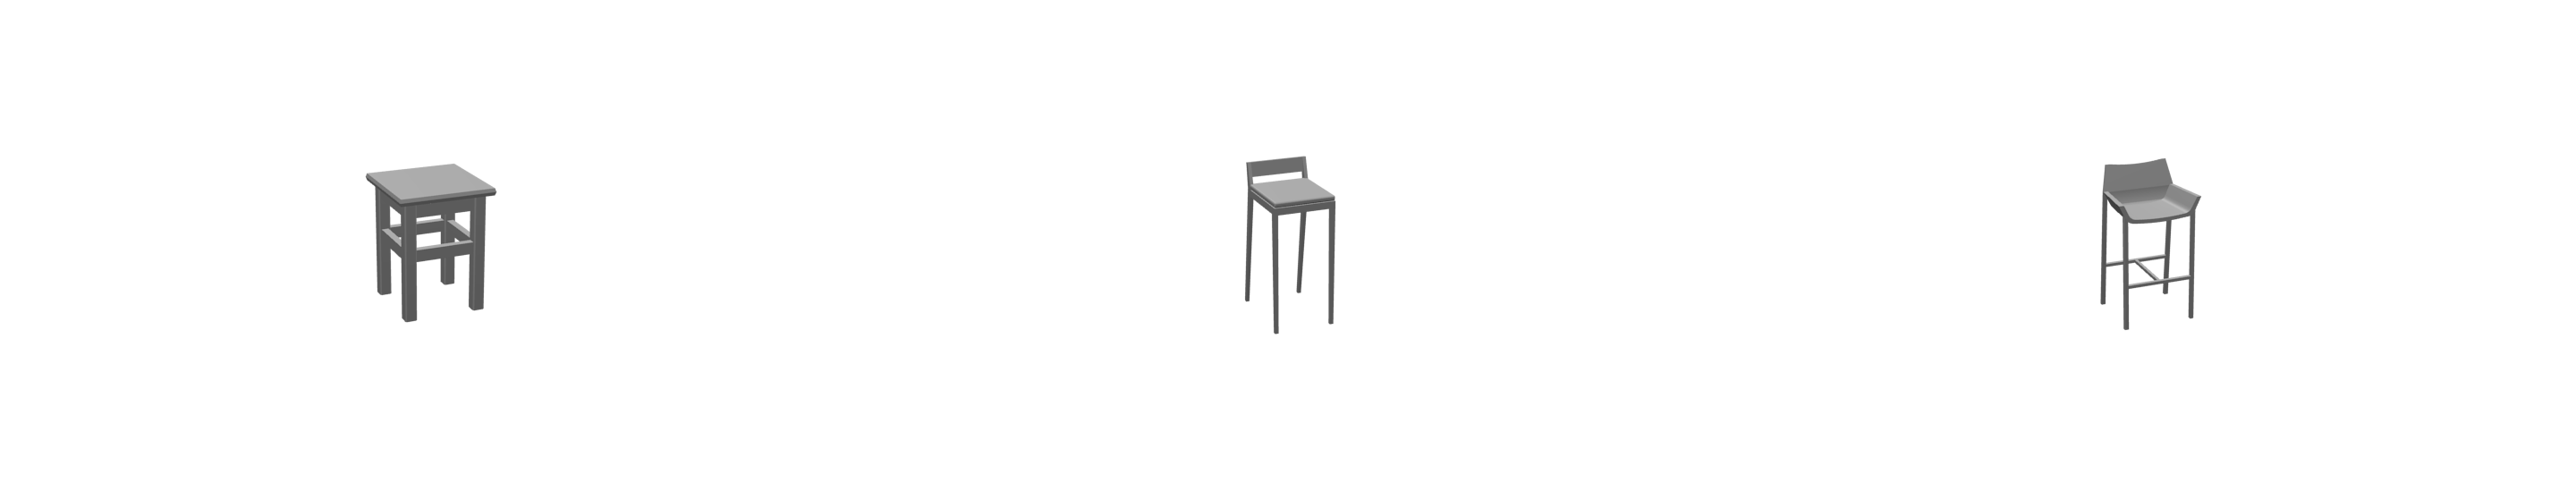

In [29]:
check = fps_sol[1]
lala = np.argsort(all_pdists[check, :])

image_files = []
image_files.append(osp.join(top_image_dir, model_ids[check], image_view_tag))
image_files.append(osp.join(top_image_dir, model_ids[lala[5]], image_view_tag))
image_files.append(osp.join(top_image_dir, model_ids[lala[8]], image_view_tag))

stack_images_horizontally(image_files)